<div class="alert alert-block alert-info">
    <img style="float: right;" src="https://raw.githubusercontent.com/OpenSourceEconomics/ose-corporate-design/master/logos/OSE_logo_RGB.svg" width="150">
    <u><h1>Dealing with selection bias</h1></u>
</div>

We need to get the Python data science stack ready.

In [1]:
import statsmodels.formula.api as smf
import pandas as pd
import numpy as np

So, we can focus on the core economics insights most of the code is available in an external module.

In [2]:
from auxiliary import plot_distribution_benefit
from auxiliary import plot_joint_distribution
from auxiliary import simulate_sample

We will first establish a flexible conceptual framework to discuss selection bias. Then we explore the distinction between selection on observables and unobservables.

<div class="alert alert-block alert-info">
    <u><h2>Simplified Roy model</h2></u>
</div>

We rely on a simple parameterization of a Roy (1951) model for the purposes of this lecture. Its potential outcome framework is particularly instructive to discuss issues of treatment effect heterogeneity and selection.


\begin{align*}\begin{array}{l@{\qquad}l}
\text{Potential outcomes} &\text{Observed outcome}\\
Y_1 = \rho\,\theta + U_1      &  Y = D Y_1 + (1 - D)Y_0 \\
Y_0 = U_0      &\\
& \\
\text{Choice} & \\
D = \mathrm{I}[\theta > 0] & \\
\end{array}
\end{align*}

We are interested to learn about the individual-specific benefit of treatment.

\begin{align}
\Delta = Y_1 - Y_0 = \rho \theta  + (U_1 - U_0)
\end{align}

We refer to $\theta$ as ability going forward. The unobservables in the potential outcome equations $(U_1, U_0)$ each follow a normal distribution with mean zero and standard deviation $0.1$. Ability is distributed according to a uniform distribution between $-0.5$ and $0.5$.

 <div class="alert alert-success">
    <h3>Questions</h3>  
     <ul>
  <li>What is observed by the econometrician and the individual and what is only observed by the individual?</li>
  <li>What is the average benefit of treatment and how does its distribution look like?</li>        
         <li>What share of individuals participates in treatment?</li>
    </ul> 
</div>

We work with a simulated example throughout and explore some issues around selection bias.


In [3]:
??simulate_sample

Signature: simulate_sample(num_persons, rho)
Source:   
def simulate_sample(num_persons, rho):
    r"""Simulate sample.

    This function simulates a sample from the simplified Roy model used during the lecture.

    Parameters
    ----------
    num_persons : int
        Number of persons to simulate.

    rho : float
        Impact of ability on potential outcomes.

    Returns
    -------

    df: pandas.DataFrame
        Data frame with observed and unobserved information about each person.

    """
    np.random.seed(123)

    index = range(num_persons)
    tuples = list(product(["observable"], ["y", "d", "t"]))
    tuples += list(product(["unobservable"], ["y1", "y0", "u1", "u0"]))
    columns = pd.MultiIndex.from_tuples(tuples)

    df = pd.DataFrame(columns=columns, index=index)
    df.index.name = "person"

    for i in range(num_persons):

        # Sample characteristics
        u1, u0 = np.random.normal(scale=0.1, size=2)
        t = np.random.uniform(-0.5, 0.5)

        #

We are now  ready to simulate as sample of $1,000$ persons with $\rho=0.5$.

In [4]:
df = simulate_sample(num_persons=1000, rho=0.5)

Let's have a brief look at the simulated dataset and discuss the properties of the observed data set.

In [5]:
df.head()

observable          unobservable                  
                y  d     t           y1    y0    u1    u0
person                                                   
0            0.10  0 -0.27        -0.25  0.10 -0.11  0.10
1            0.04  0 -0.08         0.14  0.04  0.17  0.04
2           -0.04  0 -0.16        -0.32 -0.04 -0.24 -0.04
3            0.17  0 -0.44        -0.26  0.17 -0.04  0.17
4           -0.06  0 -0.32        -0.01 -0.06  0.15 -0.06

In [6]:
df.describe()

observable                   unobservable                           
               y        d        t           y1       y0       u1       u0
count   1,000.00 1,000.00 1,000.00     1,000.00 1,000.00 1,000.00 1,000.00
mean        0.06     0.50    -0.00         0.00    -0.00     0.00    -0.00
std         0.13     0.50     0.30         0.18     0.10     0.10     0.10
min        -0.29     0.00    -0.50        -0.51    -0.29    -0.38    -0.29
25%        -0.03     0.00    -0.26        -0.12    -0.07    -0.06    -0.07
50%         0.06     1.00     0.00         0.00    -0.00     0.00    -0.00
75%         0.15     1.00     0.25         0.15     0.07     0.08     0.07
max         0.43     1.00     0.50         0.43     0.29     0.28     0.29

Going forward we will use the different parts of the dataset.

In [7]:
df_obs, df_unobs = df["observable"], df["unobservable"]

<div class="alert alert-block alert-info">
    <h3>Observables</h3>
</div>

Let's get a quick glance of the distribution of the outcome variable by treatment status?

In [8]:
df_obs.groupby("d")["y"].describe()

,count,mean,std,min,25%,50%,75%,max
d,,,,,,,,
0,499.00,-0.00,0.10,-0.29,-0.07,-0.00,0.07,0.29
1,501.00,0.13,0.12,-0.27,0.05,0.14,0.22,0.43


<div class="alert alert-block alert-info">
    <h3>Unobservables</h3>
</div>

How does the distribution of benefits look like as we vary the value of $\rho$?

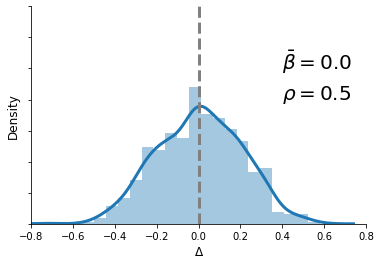

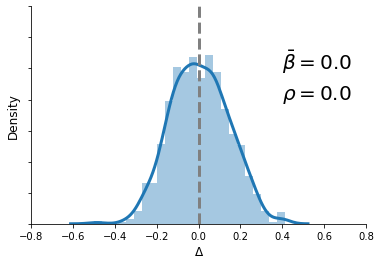

In [9]:
for rho in [0.5, 0.0]:
    plot_distribution_benefit(num_persons=1000, rho=rho)

 <div class="alert alert-success">
    <h3>Questions</h3>  
     <ul>
  <li>In what settings is a focus on average effects potentially misleading?</li>
    </ul> 
</div>



Unfortunately, it is usually impossible to learn about the whole distribution of benefits. So we will see if we can at least learn about its average.

<div class="alert alert-block alert-info">
    <h2>Naive estimate</h3>
</div>

We can now compute the **naive estimate** by looking at a simple mean comparison between the two treatment groups and compare it to the **true value**.

In [10]:
estimate = df_obs.query("d == 1")["y"].mean() - df_obs.query("d == 0")["y"].mean()
print(f"The naive estimate is {estimate:5.3f} while the true effect is 0.00.")

The naive estimate is 0.135 while the true effect is 0.00.


We can best learn about the drivers behind the discrepancy by looking at the joint distribution of ability and observed outcome.

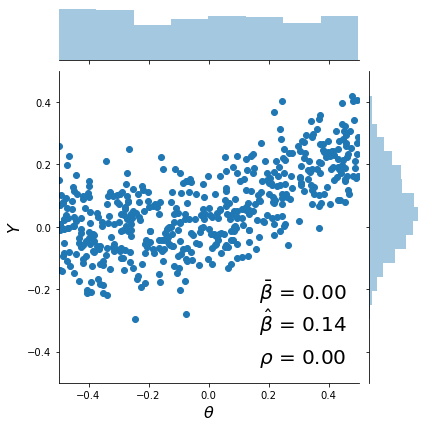

In [11]:
plot_joint_distribution(num_persons=500, rho=0.5)

 <div class="alert alert-success">
    <h3>Questions</h3>  
     <ul>
  <li>What happens if $\rho= 0$?</li>
    </ul> 
</div>

We are now ready to explore strategies to actually deal with selection bias.

<div class="alert alert-block alert-info">
    <h2>Selection on observables</h3>
</div>

In [12]:
smf.ols("y ~ d + t", data=df_obs).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.335
Model:                            OLS   Adj. R-squared:                  0.334
Method:                 Least Squares   F-statistic:                     251.4
Date:                Thu, 20 Aug 2020   Prob (F-statistic):           4.07e-89
Time:                        07:14:24   Log-Likelihood:                 815.62
No. Observations:                1000   AIC:                            -1625.
Df Residuals:                     997   BIC:                            -1611.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0591      0.008      7.628      0.000       0.044       0.074
d              0.0111      0.014      0.797      0.426      -0.016       0.038
t              0.2392      0.023     10.254      0.000       0.193       0.285
==============================================================================
Omnibus:                        3.476   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.176   Jarque-Bera (JB):                3.370
Skew:                          -0.113   Prob(JB):                        0.185
Kurtosis:                       3.173   Cond. No.                         9.22
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

What happens if we omit the observable? How severe is the problem as a function of $\rho$?

In [13]:
# We set up a prper dataframe for our experiment.
index = np.linspace(0, 0.9, num=10, endpoint=True)
columns = ["correct", "incorrect", "bias"]
rslt = pd.DataFrame(columns=columns, index=index)
rslt.index.name = r"$\rho$"

for rho in rslt.index.values:

    # We simulate a sample with varying rho
    df = simulate_sample(num_persons=10000, rho=rho)

    # We estimate the true and the biased specification
    rslt.loc[rho, "correct"] = smf.ols("y ~ d + t", data=df_obs).fit().params["d"]
    rslt.loc[rho, "incorrect"] = smf.ols("y ~ d", data=df_obs).fit().params["d"]

# We calculate the bias
rslt["bias"] = np.abs(rslt["correct"] - rslt["incorrect"])
rslt.head()

,correct,incorrect,bias
$\rho$,,,
0.00,0.01,0.14,0.12
0.10,0.01,0.14,0.12
0.20,0.01,0.14,0.12
0.30,0.01,0.14,0.12
0.40,0.01,0.14,0.12


 <div class="alert alert-success">
    <h3>Questions</h3>  
     <ul>
  <li>Why isn't the correct estimate equal to zero?</li>
    </ul> 
</div>



Accounting for selection by simply conditioning on observables is the most straightforward way to deal with selection. However, very often individuals do act on private information that remains unobserved from the perspective of the econometrician.

<div class="alert alert-block alert-info">
    <h2>Selection on unobservables</h3>
</div>

We won't have time to dive into all the other strategies at your disposal. However, let me at least briefly mention the most common ones. All of them put particular constraints on the underlying data generating process that need to be critically evaluated.

* randomized trial

* instrumental variable

* regression discontinuity design

* difference-in-difference design


<div class="alert alert-block alert-info">
    <h2>Additional resources</h3>
</div>

**Heckman, J. J., and Vytlacil, E. J. (2007a).** [Econometric evaluation of social programs, part I: Causal effects, structural models and econometric policy evaluation.](https://doi.org/10.1016/S1573-4412(07)06070-9) In J. J. Heckman, and E. E. Leamer (Eds.), Handbook of Econometrics (Vol. 6B, pp. 4779–4874). Amsterdam, Netherland: Elsevier Science.

**Heckman, J. J., and Vytlacil, E. J. (2007b).** [Econometric evaluation of social programs, part II: Using the marginal treatment effect to organize alternative economic estimators to evaluate social programs and to forecast their effects in new environments](https://doi.org/10.1016/S1573-4412(07)06071-0). In J. J. Heckman, and E. E. Leamer (Eds.), Handbook of Econometrics (Vol. 6B, pp. 4875–5144). Amsterdam, Netherland: Elsevier Science.


<div class="alert alert-block alert-info">
    <h2>References</h3>
</div>

**Angrist, J. D., & Pischke, J. (2009).** [Mostly harmless econometrics: An empiricists companion](https://www.mostlyharmlesseconometrics.com/). Princeton, NJ: Princeton University Press.

**Holland, P. W. (1986).** [Statistics and causal inference]( https://www.jstor.org/stable/2289064 ). Journal of the American Statistical Association, 81(396), 945–960.

**Roy, A. D. (1951).** [Some thoughts on the distribution of earnings]( https://www.jstor.org/stable/2662082 ). Oxford Economic Papers, 3(2), 135–146.

<div class="alert alert-block alert-info">
    <h2>Teaching portfolio</h3>
</div>


### OSE scientific computing for economists

We provide an overview of basic numerical methods, deepen our understanding in the context of dynamic model of human capital accumulation, and showcase basic software engineering practices.

**Docs** https://ose-data-science.rtfd.io

### OSE data science for economists

We study basic methods of causal inference, explore their behavior in numerous computational experiments, and apply them to research questions of interest to economists. Throughout, we ensure transparency and reproducibility of our analysis by setting up a sound computational workflow.

**Docs** https://ose-scientific-computing.rtfd.io